In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_19:00:59_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0


In [2]:
!nvidia-smi

Sun Jul  9 17:39:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.01       Driver Version: 516.01       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P0    13W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!python -m torch.utils.collect_env

PyTorch version: 2.0.1+cu117
Is debug build: False
CUDA used to build PyTorch: 11.7
ROCM used to build PyTorch: N/A

OS: Microsoft Windows 11 Home Single Language
GCC version: (tdm64-1) 10.3.0

Clang version: Could not collect
CMake version: version 3.26.0-rc3
Libc version: N/A

Python version: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:34:57) [MSC v.1936 64 bit (AMD64)] (64-bit runtime)
Python platform: Windows-10-10.0.22621
Is CUDA available: True
CUDA runtime version: 11.7.64

CUDA_MODULE_LOADING set to: LAZY
GPU models and configuration: GPU 0: NVIDIA GeForce RTX 3050 Laptop GPU
Nvidia driver version: 516.01
cuDNN version: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.7\bin\cudnn_ops_train64_8.dll
HIP runtime version: N/A
MIOpen runtime version: N/A
Is XNNPACK available: True

CPU:
Architecture=9


CurrentClockSpeed=2688


DeviceID=CPU0


Family=205


L2CacheSize=7680


L2CacheSpeed=


Manufacturer=GenuineIntel


MaxClockSpeed=2688


Name=11th Gen Intel(R) 

In [4]:
import torch
from torchvision import datasets
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, ConcatDataset, random_split, Dataset, Subset
from torchvision import transforms
from tqdm import tqdm, trange
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

In [5]:
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

True
True


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

cuda
1
0
NVIDIA GeForce RTX 3050 Laptop GPU


In [7]:
class TransformDataset(Dataset):
    def __init__(self, subset, transform=None):
        super(TransformDataset, self).__init__()
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [8]:
data = datasets.ImageFolder('celeb/')
print(len(data))

455


train_target: {'A': 22, 'B': 82, 'C': 44, 'D': 22, 'E': 47, 'F': 42, 'G': 42, 'H': 38, 'I': 74, 'J': 42}


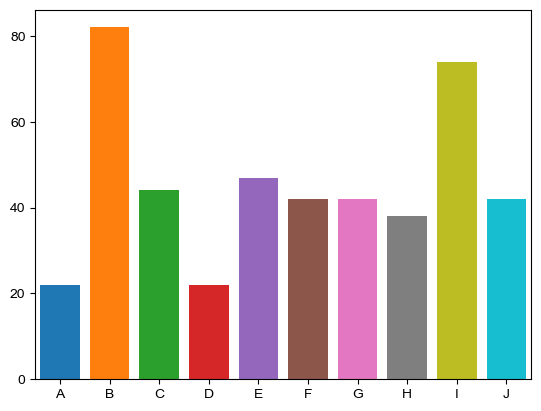

In [9]:
labels, counts = np.unique(data.targets, return_counts=True)
print('train_target:', dict(zip(list(data.class_to_idx), counts)))
sns.barplot(x=labels, y=counts, saturation=10)
sns.set_style('dark')
sns.set_theme('talk')
plt.xticks(labels, list(data.class_to_idx))
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

train_val_idx, test_idx = train_test_split(range(len(data)), test_size=0.1, stratify=data.targets, shuffle=True)
train_val_data = Subset(dataset=data, indices=train_val_idx)
test_data = Subset(dataset=data, indices=test_idx)

In [11]:
train_idx, val_idx = train_test_split(range(len(train_val_data)), test_size=0.1, stratify=list(map(lambda x: data.targets[x], train_val_idx)), shuffle=True)
train_data = Subset(dataset=train_val_data, indices=train_idx)
val_data = Subset(dataset=train_val_data, indices=val_idx)

In [12]:
def Upsample(scale=1):
    dict_train = dict(zip(*np.unique([train_data[i][1] for i in range(len(train_data))], return_counts=True)))
    list_add = []
    c_max = max(dict_train.values())
    for l, c in dict_train.items():
        n_data = scale*c_max - c
        count = 0
        while count < n_data:
            for tup in train_data:
                r = np.random.randint(2)
                if tup[1] == l and r==0:
                    list_add.append(tup)
                    count += 1
                if count == n_data:
                    break
    return list_add

In [13]:
train_data = train_data.__add__(Upsample())
dict_train = dict(zip(*np.unique([train_data[i][1] for i in range(len(train_data))], return_counts=True)))
dict_train

{0: 67, 1: 67, 2: 67, 3: 67, 4: 67, 5: 67, 6: 67, 7: 67, 8: 67, 9: 67}

In [14]:
transformer_train = transforms.Compose([transforms.Resize((128, 128)), transforms.RandomRotation((-10, 10)), transforms.ToTensor()])
transformer_val_test = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

In [15]:
up_scale_train = 1
up_scale_val = 1
up_scale_test = 1

train_data = TransformDataset(subset=ConcatDataset([train_data for _ in range(up_scale_train)]), transform=transformer_train)
val_data = TransformDataset(subset=ConcatDataset([val_data for _ in range(up_scale_val)]), transform=transformer_val_test)
test_data = TransformDataset(subset=ConcatDataset([test_data for _ in range(up_scale_test)]), transform=transformer_val_test)

In [16]:
print('train:', len(train_data))
print('val:', len(val_data))
print('test:', len(test_data))
print('total dataset:', len(train_data) + len(val_data) + len(test_data))

train: 670
val: 41
test: 46
total dataset: 757


In [17]:
class MyCNN(nn.Module):
        def __init__(self, in_channel, out_channel, n_classes=10):
            super(MyCNN, self).__init__()

            self.conv1 = nn.Conv2d(in_channel, 32, 3)
            nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
            self.dropout1 = nn.Dropout2d(0.5)

            self.batch1 = nn.BatchNorm2d(32)
            self.maxpooling1 = nn.MaxPool2d(3)

            self.conv2 = nn.Conv2d(32, 64, 3)
            nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
            self.dropout2 = nn.Dropout2d(0.5)

            self.batch2 = nn.BatchNorm2d(64)
            self.maxpooling2 = nn.MaxPool2d(3)

            self.fc1 = nn.Linear(out_channel * 13 * 13, n_classes)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            x = self.dropout1(x)
            # print(x.shape)
            x = self.batch1(x)
            # print(x.shape)
            x = self.maxpooling1(x)
            # print(x.shape)
            x = F.relu(self.conv2(x))
            x = self.dropout2(x)
            # print(x.shape)
            x = self.batch2(x)
            # print(x.shape)
            x = self.maxpooling2(x)
            # print(x.shape)
            out = self.fc1(x.view(x.size(0), -1))
            # print(out.shape)
            return out

In [18]:
mycnn = MyCNN(in_channel=3, out_channel=64).to(device)
print(torch.max(mycnn(train_data[0][0].reshape(1, 3, 128, 128).to(device)), dim=-1))
print(mycnn)

torch.return_types.max(
values=tensor([0.6113], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([5], device='cuda:0'))
MyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpooling1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpooling2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10816, out_features=10, bias=True)
)


In [19]:
optimzer = optim.Adam(params=mycnn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def my_train(model, optimizer, criterion, train, val, batch_size, shuffle=True, epochs=1):
    trainloader = DataLoader(dataset=train, batch_size=batch_size, shuffle=shuffle)
    valloader = DataLoader(dataset=val, batch_size=batch_size, shuffle=shuffle)
    batches_per_epoch = len(trainloader)
    history = {'train_acc':[],
               'train_loss':[],
               'val_acc':[]}
    for epoch in tqdm(range(epochs)):
        with trange(batches_per_epoch, unit='batch') as pbar:
            pbar.set_description(f'{epoch + 1} epoch(s)')
            
            # train mode
            train_loss = 0
            train_acc = 0
            model.train()
            for x, y in trainloader:
                optimizer.zero_grad()
                x, y = x.to(device), y.to(device)
                yhat = model(x)
                _, label = torch.max(yhat, dim=-1)
                loss = criterion(yhat, y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_acc += (label==y).sum().item()
                pbar.update()

            train_acc = round(train_acc/len(train), 3)
            history['train_loss'].append(loss)
            history['train_acc'].append(train_acc)

            # eval mode
            val_acc = 0
            model.eval()
            for x, y in valloader:
                x, y = x.to(device), y.to(device)
                _, label = torch.max(model(x), dim=-1)
                val_acc += (label==y).sum().item()

            val_acc = val_acc/len(val)
            history['val_acc'].append(val_acc)

            pbar.set_postfix_str(f'train_loss: {train_loss} train_acc: {train_acc} val_acc: {val_acc}')


In [20]:
my_history = my_train(mycnn, optimzer, criterion, train_data, val_data, batch_size=32, shuffle=True, epochs=10)

100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


In [21]:
testloader = next(iter(DataLoader(dataset=test_data, batch_size=len(test_data), shuffle=True)))
X_test = testloader[0].to(device)
y_test = testloader[1].to(device)

In [22]:
mycnn.eval()
_, label = torch.max(mycnn(X_test), dim=-1)

In [23]:
print('test acc:', (label == y_test).sum().item()/len(y_test)) 

test acc: 0.5217391304347826


In [24]:
print(mycnn)

MyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpooling1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpooling2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10816, out_features=10, bias=True)
)
